In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import k_clique_communities
from scipy.sparse.csgraph import connected_components

# Slava requested to add the following:
import sys
import warnings
warnings.filterwarnings('ignore')
print("Python version:", sys.version)
print("NetworkX version:", nx.__version__)

Python version: 3.8.13 (default, Apr 19 2022, 00:53:22) 
[GCC 7.5.0]
NetworkX version: 2.7.1


# Question 1

### A

In [2]:
def get_kth_non_overlapping_communities(G, k):
    G_copy = G.copy()
    communities = [comp for comp in nx.connected_components(G_copy)]
    while len(communities) != k:
        edge_betweenes = nx.edge_betweenness_centrality(G_copy)
        u, v = max(edge_betweenes, key=edge_betweenes.get)
        G_copy.remove_edge(u, v)
        communities = [comp for comp in nx.connected_components(G_copy)]
    return communities

In [3]:
# TEST
for i in range(50):
    p, k = (np.random.rand()+1)/2, np.random.randint(2, 5)
    G = nx.erdos_renyi_graph(20, p)
    our_communities = get_kth_non_overlapping_communities(G, k)
    nx_communities = girvan_newman(G)
    nx_communities = list([comp for comp in nx_communities if len(comp) == k][0])
    assert(our_communities == nx_communities)
print('SUCCESS')

SUCCESS


### B

In [4]:
slava_graph = pd.read_csv('communities.csv', sep=' ', header=None)
G = nx.empty_graph(slava_graph.max().max())
for index, (u, v) in slava_graph.iterrows():
    G.add_edge(u, v)
largest_CC_index = np.argmax([len(comp) for comp in nx.connected_components(G)])
largest_CC = [comp for comp in nx.connected_components(G)][largest_CC_index]
G = G.subgraph(largest_CC)

In [5]:
pos = nx.spring_layout(G)  # positions for all nodes
communities = get_kth_non_overlapping_communities(G, 3)

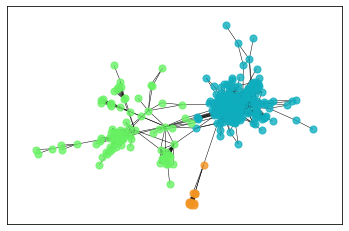

In [6]:
nx.draw_networkx_edges(G, pos, width=0.5, alpha=1)
for comp, color in zip(communities, ['#0FAEBF', '#68F263', '#F29422']):
    nx.draw_networkx_nodes(G, pos, nodelist=comp,
                           node_color=color,
                           node_size=50,
                           alpha=0.8)
plt.show()

# Question 2

### A

In [7]:
def get_kth_clique_communities(G, k):
    
    cliques = [(index, set(clique)) for index, clique in enumerate(nx.find_cliques(G))]
    clique_overlap_matrix = np.zeros((len(cliques),len(cliques)))
    np.fill_diagonal(clique_overlap_matrix, -1) # threshold for diagonal is k (and not k-1)

    for (idx_1, clique_1), (idx_2, clique_2) in product(cliques, cliques):
        clique_overlap_matrix[idx_1,idx_2] += len(clique_1 & clique_2)
            
    clique_overlap_matrix = (clique_overlap_matrix >= (k-1)).astype(int)

    n_components, CC = connected_components(clique_overlap_matrix)

    communities = [set() for i in range(n_components)]
    
    for (index, clique), comp in zip(cliques, CC):
        if clique_overlap_matrix[index, index]:
            communities[comp] = communities[comp].union(clique)

    communities = [c for c in communities if len(c) > 0]
    
    return communities

In [8]:
# TEST
for i in range(50):
    p, k = (np.random.rand()+1)/2, np.random.randint(3, 5)
    G = nx.erdos_renyi_graph(5, p)

    our_communities = get_kth_clique_communities(G, k)

    nx_communities = k_clique_communities(G, k)
    nx_communities = [set(comp) for comp in nx_communities]


    if our_communities != nx_communities:
        msg = f"k = {k}, p = {p}\nour_communities = {our_communities}\nnx_communities = {nx_communities}"
        nx.draw_networkx(G)
        raise Exception(msg)

print('SUCCESS')

SUCCESS


### B

In [9]:
slava_graph = pd.read_csv('communities.csv', sep=' ', header=None)
G = nx.empty_graph(slava_graph.max().max())
for index, (u, v) in slava_graph.iterrows():
    G.add_edge(u, v)
largest_CC_index = np.argmax([len(comp) for comp in nx.connected_components(G)])
largest_CC = [comp for comp in nx.connected_components(G)][largest_CC_index]
G = G.subgraph(largest_CC)

In [10]:
communities = get_kth_clique_communities(G, 4)
for i, comp in enumerate(communities): print(f'Community number {i}\n', list(comp), '\n')

Community number 0
 [1, 3, 5, 7, 9, 10, 13, 16, 21, 22, 24, 25, 26, 27, 29, 30, 31, 36, 38, 39, 40, 45, 48, 50, 53, 54, 55, 56, 57, 59, 60, 62, 63, 64, 65, 66, 67, 69, 72, 73, 75, 77, 79, 80, 82, 84, 85, 87, 88, 92, 94, 96, 98, 100, 101, 103, 104, 105, 106, 108, 109, 113, 118, 119, 121, 122, 123, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 139, 141, 142, 146, 148, 150, 156, 158, 159, 161, 163, 165, 168, 169, 170, 171, 172, 176, 178, 180, 184, 185, 186, 187, 188, 189, 194, 196, 197, 199, 200, 203, 204, 208, 211, 212, 213, 217, 221, 222, 223, 224, 229, 231, 232, 236, 238, 239, 242, 246, 248, 249, 250, 251, 252, 254, 257, 258, 261, 265, 266, 268, 271, 272, 274, 276, 277, 280, 281, 284, 285, 290, 291, 295, 297, 298, 299, 300, 302, 303, 304, 308, 309, 313, 314, 315, 317, 318, 320, 322, 323, 324, 325, 329, 330, 331, 332, 334, 338, 339, 340, 341, 342, 344, 345, 346, 347] 

Community number 1
 [2, 326, 137, 140, 333, 14, 144, 17, 337, 19, 20, 149, 214, 343, 151, 28, 93, 32, 226, 162, 167

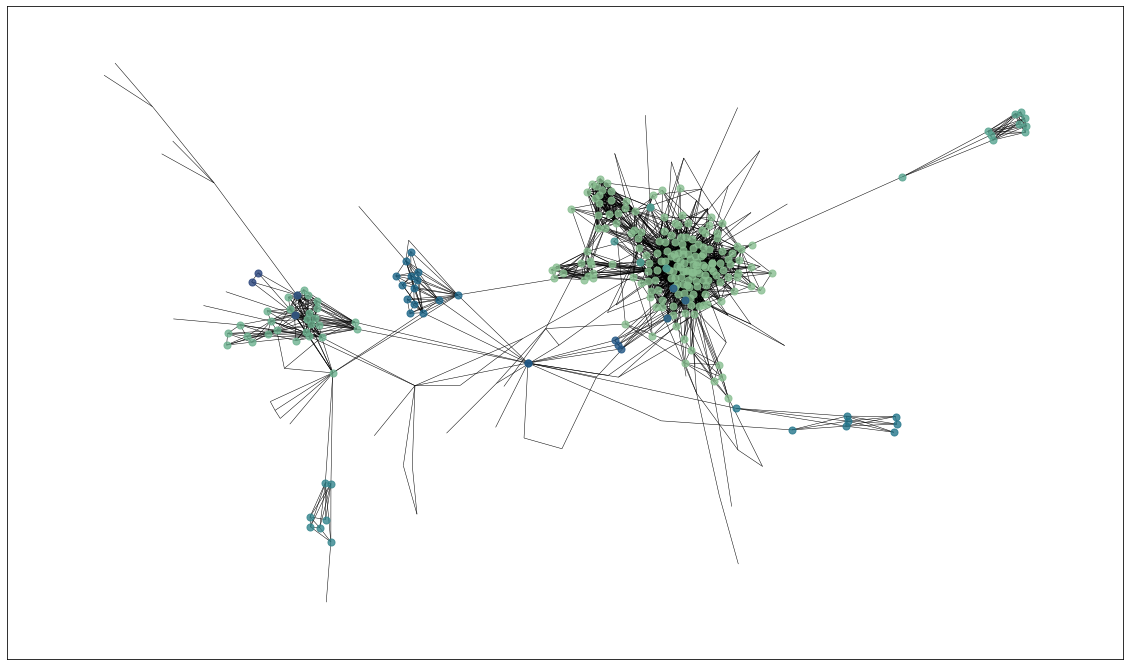

In [11]:
fig, ax = plt.subplots(1,1,figsize=(20,12))
pos = nx.spring_layout(G)  # positions for all nodes
palette = sns.color_palette('crest', len(communities))

nx.draw_networkx_edges(G, pos, width=0.5, alpha=1) 
for i, comp in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=comp,
                           node_color=np.array([palette[i]]),
                           node_size=50,
                           alpha=0.8, ax=ax)
plt.show()